# **Evolutionary Algorithms Project**
**Module:** CS6271 - Evolutionary Algorithms and Humanoid Robotics

**Module Leader:** Conor Ryan

**Developers:** Fethi Denker (24088919) and Cheyenne Goh (24044342)

*Adapted from sample code prepared by Allan De Lima.*


## Introduction

Mount Google Drive if running on Google Colab runtime.

In [1]:
try:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    print('Running on Google Colab runtime')
except:
    print('Running on local runtime')

Running on local runtime


Install DEAP and import required libraries.

In [2]:
!pip install deap

import warnings
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import csv
import textwrap
from sklearn.feature_selection import SelectKBest, chi2

from deap import creator, base, tools

Set random seed.

In [3]:
RANDOM_SEED = 2
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Suppress warnings.

In [4]:
warnings.filterwarnings("ignore")

## Dataset

### Load the dataset

Clone the GRAPE repository and import libraries.

In [5]:
# Copy the path from your drive
PATH = '/content/drive/MyDrive/grape/'

# Check if 'grape' already exists
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/bdsul/grape.git
    print('Cloning grape in your Drive')

# Change directory to 'grape'
%cd /content/drive/MyDrive/grape/

import grape
import algorithms
from functions import add, sub, mul, psin, and_, or_, not_, nand_, nor_, less_than_or_equal, greater_than_or_equal

grape directory already exists
C:\content\drive\MyDrive\grape


### Train and test sets

Read train and test sets into a dataframe.

In [6]:
train_file = 'datasets/train.csv'
test_file = 'datasets/test.csv'

# Load train and test sets
df_train = pd.read_csv(PATH + train_file)
df_test = pd.read_csv(PATH + test_file)

Pre-process the dataset.

In [7]:
def standardise(data, columns):
    """ Applies z-score normalisation independently for each feature in a
    dataset.

    Args:
        columns: List of columns to apply standardisation to
        data: A Pandas Dataframe

    Returns:
        Pandas Dataframe with standarisation applied
    """
    data.loc[:, columns] = (data.loc[:, columns] - data.loc[:, columns].mean()) / data.loc[:, columns].std()
    return data

def rank_features(X_train, y_train):
    """ Ranks features by chi-squared statistic from greatest to least.

    Args:
        X_train: A Pandas dataframe of training features
        y_train: A numpy array containing expected training classes

    Returns:
        List of columns ranked by chi-squared statistic
    """
    BestFeatures = SelectKBest(score_func=chi2)
    fit = BestFeatures.fit(X_train, y_train)
    f_scores = pd.DataFrame({'Feature': X_train.columns.to_list(), 'Score': fit.scores_})
    f_scores = f_scores.sort_values('Score', ascending=False)
    return f_scores['Feature']

X_train = df_train.copy()
X_test = df_test.copy()

# Drop duplicate samples
X_train.drop_duplicates()

X_train = X_train.drop(['output'], axis=1)
y_train = df_train['output'].to_numpy()

# Rank features by chi-squared statistic
rank_cols = rank_features(X_train, y_train)

# Apply standardisation to both train and test, assuming that the mean and
# standard deviation of both sets are similar
all_cols = X_train.columns.to_numpy()
X_train = standardise(X_train, all_cols)
X_test = standardise(X_test, all_cols)

Print ranked input features.

In [8]:
inputs = {}
for i in range(len(all_cols)):
    inputs[all_cols[i]] = f'x[{i}]'

for col in rank_cols:
    print(f'{inputs[col]}\t{col}')

x[15]	PhysHlth
x[3]	BMI
x[14]	MentHlth
x[13]	GenHlth
x[18]	Age
x[0]	HighBP
x[16]	DiffWalk
x[6]	HeartDiseaseorAttack
x[1]	HighChol
x[20]	Income
x[5]	Stroke
x[10]	HvyAlcoholConsump
x[19]	Education
x[7]	PhysActivity
x[4]	Smoker
x[9]	Veggies
x[8]	Fruits
x[17]	Sex
x[12]	NoDocbcCost
x[2]	CholCheck
x[11]	AnyHealthcare


Convert the datasets to NumPy to easily use them.

In [9]:
X_train = X_train.to_numpy(dtype=np.float32)
X_test = X_test.to_numpy(dtype=np.float32)

# Transpose data for compatibility with GRAPE
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

## GRAPE

Define functions that are not available in GRAPE.

In [10]:
def xor_(a, b):
    """ Exclusive OR operation.

    Args:
        a: A binary value
        b: A binary value

    Returns:
        Result of bitwise exclusive OR operation.
    """
    return or_(and_(a, not_(b)), and_(not_(a), b))

def xnor_(a, b):
    """ Exclusive NOR operation.

    Args:
        a: A binary value
        b: A binary value

    Returns:
        Result of bitwise exclusive NOR operation.
    """
    return not_(xor_(a, b))

def aq(a, b):
    """ Analytic quotient operation.

    Args:
        a: A numerical value
        b: A numerical value

    Returns:
        Result of analytic quotient operation
    """
    return a / np.sqrt(1 + b ** 2)

def neg(a):
    """ Negation operation.

    Args:
        a: A numerical value

    Returns:
        Result of negation operation
    """
    return -a

def ptanh(a):
    """ Protected hyperbolic tangent function.

    Args:
        a: A numerical value

    Returns:
        Result of protected hyperbolic tangent function
    """
    return np.tanh(a)

Define the fitness function.

In [11]:
def fitness_eval(individual, points):
    """ Calculates fitness measure by computing the percentage of outputs
    wrongly predicted.

    Args:
        individual: A deap.creator.Individual object
        points: A tuple of numpy arrays containing input and output data

    Returns:
        A tuple containing the fitness
    """
    x, Y = points

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        return np.NaN,
    assert np.isrealobj(pred)

    compare = np.equal(Y,pred)
    fitness = 1 - np.mean(compare)

    return fitness,

Define a function to create a toolbox.

In [12]:
def create_toolbox():
    """ Creates a toolbox using primitive set and declared parameters.

    Args:
        primitiveSet: A deap.gp.PrimitiveSet object

    Returns:
        A deap.base.Toolbox object
    """
    toolbox = base.Toolbox()

    # Define a single objective, minimising fitness strategy
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

    creator.create('Individual', grape.Individual, fitness=creator.FitnessMin)

    # Sensible initialisation
    toolbox.register("populationCreator", grape.sensible_initialisation, creator.Individual)

    toolbox.register("evaluate", fitness_eval)

    # Tournament selection
    toolbox.register("select", tools.selTournament, tournsize=TOURNAMENT_SIZE)

    # Single-point crossover
    toolbox.register("mate", grape.crossover_onepoint)

    # Flip-int mutation
    toolbox.register("mutate", grape.mutation_int_flip_per_codon)

    return toolbox

Define a function to run Grammatical Evolution.

In [13]:
def grammatical_evolution(X_train, y_train, toolbox):
    """Runs through the main GE flow N_RUNS times.

    Args:
        X_train: A numpy array containing training features
        y_train: A numpy array containing expected training classes
        toolbox: A deap.base.Toolbox object

    Returns:
        A tuple of tuples of lists of average, standard deviation, minimum and
        maximum statistics for fitness and size
    """

    best_individuals = []
    train_fitnesses = []
    best_logbook = []

    for i in range(N_RUNS):

        # Create our statistics
        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        print(f"\nRun: {i + 1}/{N_RUNS}\n")

        # Create initial population (generation 0)
        population = toolbox.populationCreator(pop_size=POPULATION_SIZE,
                                              bnf_grammar=BNF_GRAMMAR,
                                              min_init_depth=MIN_INIT_TREE_DEPTH,
                                              max_init_depth=MAX_INIT_TREE_DEPTH,
                                              codon_size=CODON_SIZE,
                                              codon_consumption=CODON_CONSUMPTION,
                                              genome_representation=GENOME_REPRESENTATION)

        # Define the hall-of-fame object
        hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

        # Prepare the statistics object
        stats = tools.Statistics(key=lambda ind: ind.fitness.values)
        stats.register("avg", np.nanmean)
        stats.register("std", np.nanstd)
        stats.register("min", np.nanmin)
        stats.register("max", np.nanmax)

        population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                                                ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                                                bnf_grammar=BNF_GRAMMAR,
                                                                codon_size=CODON_SIZE,
                                                                max_tree_depth=MAX_TREE_DEPTH,
                                                                max_genome_length=MAX_GENOME_LENGTH,
                                                                points_train=[X_train, y_train],
                                                                codon_consumption=CODON_CONSUMPTION,
                                                                report_items=REPORT_ITEMS,
                                                                genome_representation=GENOME_REPRESENTATION,
                                                                stats=stats, halloffame=hof, verbose=False)

        # Best individual
        best = hof.items[0]
        best_train_fitness = best.fitness.values[0]

        print("\nBest individual: \n" + "\n".join(textwrap.wrap(best.phenotype,80)))
        print("\nTraining fitness: ", best_train_fitness)

        best_individuals.append(best)
        train_fitnesses.append(best_train_fitness)
        logbooks.append(logbook)

        print("Depth: ", hof.items[0].depth)
        print("Length of the genome: ", len(hof.items[0].genome))
        print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

    best_index = np.argmin(train_fitnesses)
    best_individual = best_individuals[best_index]
    best_train_fitness = train_fitnesses[best_index]
    best_logbook = logbooks[best_index]

    print("\n\nBest individual of setup: \n" + "\n".join(textwrap.wrap(best_individual.phenotype,80)))
    print("\nTraining fitness: ", best_train_fitness)

    return best_individual, best_train_fitness, best_logbook

Define function to plot statistics.

In [14]:
def plotFitness(logbook):
    """Plots fitness statistics.

    Args:
        logbook: A deap.tools.support.Logbook object
    """

    gen = np.arange(0, MAX_GENERATIONS+1)

    mean_fitness_values, std_fitness_values = logbook.select("avg", "std")
    min_fitness_values = logbook.select("min")

    plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values, color='green', label="Average")
    plt.plot(min_fitness_values, color='red', label='Best individual')
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title('Fitness over Generations')
    plt.show()

    return

def plotGenomeLength(logbook):
    """Plots genome length statistics.

    Args:
        logbook: A deap.tools.support.Logbook object
    """

    best_ind_length = logbook.select("best_ind_length")
    avg_length = logbook.select("avg_length")

    plt.plot(avg_length, color='blue', label="Average")
    plt.plot(best_ind_length, color='green', label="Best individual")
    plt.legend()
    plt.xlabel('Generation')
    plt.ylabel('Genome Length')
    plt.title('Genome Length over Generations')
    plt.show()

    return

Set parameters and run `N_SETUPS` setups.

In [15]:
POPULATION_SIZE = 1600
MAX_GENERATIONS = 100
P_CROSSOVER = 0.7
P_MUTATION = 0.01
ELITE_SIZE = 10
HALL_OF_FAME_SIZE = 10

TOURNAMENT_SIZE = 4

CODON_CONSUMPTION = 'lazy'
GENOME_REPRESENTATION = 'list'
MAX_GENOME_LENGTH = None

MAX_INIT_TREE_DEPTH = 13
MIN_INIT_TREE_DEPTH = 3
MAX_TREE_DEPTH = 90
MAX_WRAPS = 0
CODON_SIZE = 255

REPORT_ITEMS = ['gen', 'invalid', 'avg', 'std', 'min', 'max',
                'best_ind_length', 'avg_length',
                'best_ind_nodes', 'avg_nodes',
                'best_ind_depth', 'avg_depth',
                'avg_used_codons', 'best_ind_used_codons',
                'structural_diversity', 'fitness_diversity',
                'selection_time', 'generation_time']

N_RUNS = 100

N_FEATURES = 10
GRAMMAR_FILE = f'diabetes{N_FEATURES}.bnf'
BNF_GRAMMAR = grape.Grammar('/content/' + GRAMMAR_FILE)

individuals = []
train_fitnesses = []
# setups = []
logbooks = []

n_setups = 1
for s in range(n_setups):
    print(f"\n\nSetup: {s + 1}/{n_setups}")

    # Create toolbox
    toolbox = create_toolbox()

    # Run GE
    individual, train_fitness, logbook = grammatical_evolution(X_train, y_train, toolbox)

    individuals.append(individual)
    train_fitnesses.append(train_fitness)
    # setups.append({})
    logbooks.append(logbook)

Streaming output truncated to the last 5000 lines.
Used portion of the genome: 0.11

Run: 59/100

gen = 0 , Best fitness = (0.2945259817532725,)
gen = 1 , Best fitness = (0.2760809202697342,) , Number of invalids = 298
gen = 2 , Best fitness = (0.2760809202697342,) , Number of invalids = 245
gen = 3 , Best fitness = (0.2760809202697342,) , Number of invalids = 185
gen = 4 , Best fitness = (0.2760809202697342,) , Number of invalids = 169
gen = 5 , Best fitness = (0.27191590638635466,) , Number of invalids = 108
gen = 6 , Best fitness = (0.27191590638635466,) , Number of invalids = 101
gen = 7 , Best fitness = (0.2653708845696152,) , Number of invalids = 82
gen = 8 , Best fitness = (0.2653708845696152,) , Number of invalids = 69
gen = 9 , Best fitness = (0.2618008726695755,) , Number of invalids = 80
gen = 10 , Best fitness = (0.2618008726695755,) , Number of invalids = 78
gen = 11 , Best fitness = (0.2618008726695755,) , Number of invalids = 75
gen = 12 , Best fitness = (0.2588258627528

Print best individual.

In [16]:
best_index = np.argmin(np.array(train_fitnesses))
best_individual = individuals[best_index]
best_train_fitness = train_fitnesses[best_index]
# best_setup = setups[best_index]
best_logbook = logbooks[best_index]

print("Overall best individual:\n" + "\n".join(textwrap.wrap(best_individual.phenotype,80)))
print("\nTraining fitness:", best_train_fitness)
# print("Best setup:", best_setup)

Overall best individual:
greater_than_or_equal(add(add(psin(ptanh(x[13])),add(add(x[13],x[0]),psin(x[18])
)),mul(x[18],x[3])),sub(add(sub(neg(x[3]),psin(x[6])),aq(mul(x[18],x[18]), psin(
ptanh(x[6])))),sub(add(add(psin(ptanh(x[13])),add(add(x[13],x[3]),psin(x[18]))),
mul(x[15],x[3])),sub(add(sub(neg(x[1]),ptanh(x[6])),1.161),neg(aq(x[13],
sub(aq(sub(sub(x[13],sub(add(sub(neg(aq(x[13],
x[6])),x[6]),mul(7.092,neg(x[3]))),ptanh(x[6]))),sub(mul(x[18],x[18]),aq(x[15],
x[3]))), aq(-3.592, sub(add(sub(x[18],mul(add(mul(sub(9.280,x[3]),ptanh(x[6])),s
ub(4.479,-7.021)),aq(psin(x[0]), -8.420))),-
2.000),mul(x[18],x[0])))),mul(add(psin(x[13]),add(add(x[13],x[3]),psin(x[18]))),
mul(x[18],x[3])))))))))

Training fitness: 0.2413724712415708


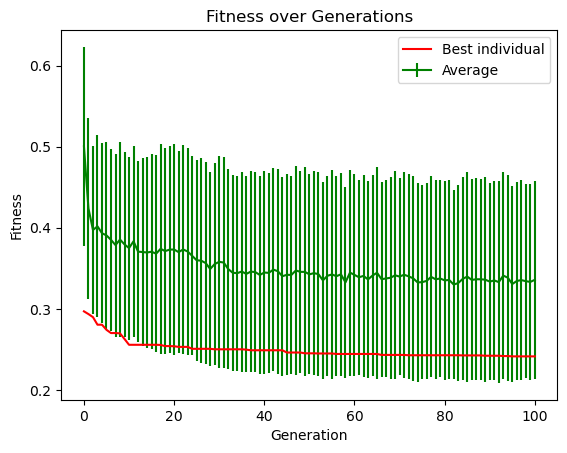

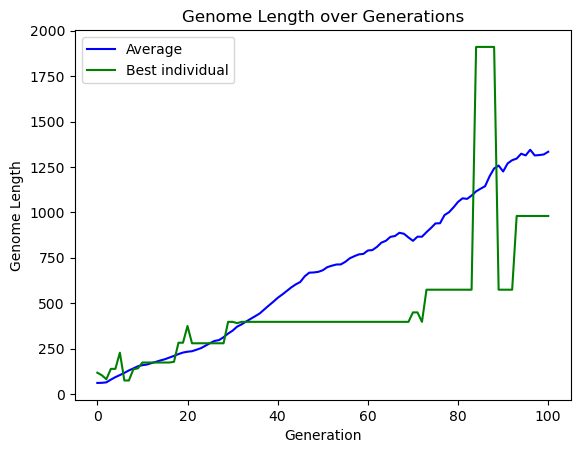

In [17]:
# Plotting and confusion matrix
plotFitness(logbook)
plotGenomeLength(logbook)

Define a function to predict values, without
comparing to expected outputs.

In [18]:
def predict(individual, X):
    """ Predict values from input by evaluating an individual.

    Args:
        individual: A deap.creator.Individual object
        points: A tuple of numpy arrays containing input and output data

    Returns:
        List of predicted values
    """
    x = X

    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        return np.NaN,
    assert np.isrealobj(pred)

    return pred

Display confusion matrix.

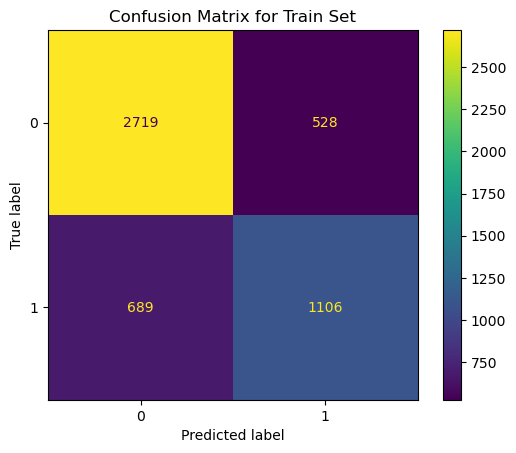

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_train, predict(best_individual, X_train))
ConfusionMatrixDisplay(cm).plot()
plt.title('Confusion Matrix for Train Set')
plt.show()

Predict the classes of the test set.

In [20]:
y_pred = predict(best_individual, X_test)
print("Predicted classes of the test set:", y_pred)

Predicted classes of the test set: [ True  True False ... False  True False]


Create output file for submission.

In [21]:
# Create formatted .csv file
output = pd.DataFrame(y_pred.astype(int), columns=['output'])

output_dir = '/content/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
output.to_csv(output_dir + 'output.csv', index_label='index')